# [Weather data and solar radiation](01WeatherData.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall](02SimpleWall.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubicBuilding.ipynb)

# Thermal circuits assembling

**Objectives:**
- Obtain the thermal model by assembling thermal circuits.
- Convert thermal circuit to state-space representation.
- Simulate the assembled circuits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

## Defining the problem of circuit assembling

The problem of assembling thermal circuits can be stated as:

> Given a number of disassembled thermal circuits, $TCd_1$, $TCd_2$, ... , $TCd_n$, and knowing that some of their nodes are common, find the assembled thermal circuit $TC$ (see Figure 1).

To exemplify the procedure, we will use the same model as in tutorial [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubicBuilding.ipynb)
 representing a room with an insulated concrete wall and a glass wall. The room is ventilated and the indoor air temperature is controlled by a P-controller. This [toy model](https://en.m.wikipedia.org/wiki/Toy_model) is used to explain the assembling procedure, not for the correctness of the modelling.

![assembling](./figures/04_assembling.png)
> Figure 1. Example of the problem of assembling thermal circuits: given four circuits, TCd0, ..., TCd3, assemble them knowing the following nodes are common to two or more circuits:
> - Node 4 of circuit TCd0 (in red) is in common with node 0 of circuit TCd1 (in blue).
> - Node 1 of circuit TCd1 (in blue) is in common with node 1 of circuit TCd2 (in green).
> - Node 2 of circuit TCd1 (in blue) is in common with node 0 of circuit TCd3 (in violet).

![circuit](./figures/04_circuit.png)
> Figure 2. Thermal circuit obtained by assembling elementary circuits TCd0, ..., TCd3. The heat-flow sources and the capacities in a node are the sum of those of each circuit. The numbers in black correspond to the global indexing and the numbers in colors (red, blue, green and violet) correspond to the local indexing.

![matrices](./figures/04_matrices.png)
> Figure 3. Algebraic representation of the thermal circuit: 
> - a) assembly-connectivity matrix; 
> - b) elementary thermal circuits, TCd0, ..., TCd3, characterized by the matrices $A, G, C$ and the vectors $b, f$.

From the conservation of energy, it results that if there is a flow source in the common node of the assembled circuit, it needs to be the sum of the sources from the corresponding node of each elementary circuit. For example, the source in node 4 of the assembled circuit is the sum of the sources from node 4 of TCd0 and node 0 of TCd1 (Figure 2). From the conservation of mass, it results that if there is a common capacity in the node of the assembled circuit, it needs to be the sum of the capacities present in the corresonding node of each elemendaty circuit. For example, the capacity in node 6 of the assembled circuit is the sum of the capacities of node 2 of TCd1 and of node 0 of TCd3. 

We would like to construct separate models for the disassembled thermal circuits (e.g., for concrete wall TCD0, room air TCd1, glass wall TCd2, ventilation and HVAC system TCd2) and to assemble them into a single thermal circuit.

## Numbering the circuits

### Numbering elementary circuits

In principle, the numbering of the nodes and the branches can be done arbitrarily. The connections are indicated by the oriented incidence matrix $A$. Since numbering becomes tedious for large circuits, the following rules may be adopted:
- number the nodes in order (e.g. from left to right and top to bottom);
- number the branches in increasing order of nodes and direct them from the lower to the higher node number.

### Numbering the assembled circuit
When assembling the thermal circuits, some nodes are put in common. Therefore, the number of nodes in the assembled circuit will be smaller than the sum of the nodes of the elementary circuits. However, the number of branches will not change. The nodes and the branches of the assembled circuit will be in the order of assembling.

|Local and global indexing of nodes|
|----------------------------------|

|Thermal circuit  |TCd0      |TCd1    |TCd2 |TCd3|
|-----------------|:--------:|:------:|:---:|:--:|
|Local node index |0 1 2 3 4 |0 1  2  |0  1 |0   |
|Global node index|0 1 2 3 4 |4 5  6  |7  5 |6   |

|Local and global indexing of branches|
|-------------------------------------|

|Thermal circuit    |TCd0      |TCd1  |TCd3 |TCd3 |
|-------------------|:--------:|:----:|:---:|:---:|
|Local branch index |0 1 2 3 4 |0 1 2 |0 1  | 0  1|
|Global branch index|0 1 2 3 4 |5 6 7 |8 9  |10 11|

The assembling of the circuits is described by the assembling matrix. Each row of this matrix has four elements that indicate the two nodes that will be put together:
1. index of the 1st circuit
2. node of the 1st circuit
3. index of the 2nd circuit 
4. node of the 2nd circuit

For our example, the assembling matrix is:

$$A_{ss} =\begin{bmatrix}
0 & 4 & 1 & 0\\ 
1 & 1 & 2 & 1\\ 
1 & 2 & 3 & 0
\end{bmatrix}$$

meaning that:
- circuit TCd0, node 4, identic with circuit TCd1, node 0;
- circuit TCd1, node 1, identic with circuit TCd2, node 1;
- circuit TCd1, node 2, identic with circuit TCd3, node 0.

The description of the disassembled circuits, given by the [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) $TC_d = \{TC_0,…, TC_i,…, TC_n\}$ of [dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) $TC_i=\{A_i,G_i,b_i,C_i,f_i,y_i\}$, and the assembling matrix $A_{ss}$ contain all the necessary information for obtaining the assembled circuit. 

## Conductances and capacities

Let's consider the same geometry and thermophysical properties as in Tutorial 3.

In [2]:
# Dimensions and surface areas of the building
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
Va = l**3           # m³ volume of air

# Thermophysical properties of the air (in SI units) 
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/m.K
        'Density': [2300, 55, 2500],        # kg/m³
        'Specific heat': [880, 1210, 750],  # J/kg.K
        'Width': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Meshes': [1, 1, 1]}                # number of meshes
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])

# Radiative properties
ε_wLW = 0.85    # long wave emmisivity wall concrete
ε_gLW = 0.90    # long wave emmisivity glass pyrex
α_wSW = 0.25    # short wave absortivity white smooth surface
α_gSW = 0.38    # short wave absortivity reflective blue glass
τ_gSW = 0.30    # short wave transmitance reflective blue glass

# Stefan-Boltzmann constant
σ = 5.67e-8     # W/m²⋅K⁴ Stefan-Bolzmann constant

# View factor
Fwg = 1 / 5     # view factor wall - glass

Tm = 20 + 273   # mean temp for radiative exchange

# Convection coeficients
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/m²⋅K

The HVAC system can be modelled as a proportional controller with the gain $K_p$:
* If $K_p \rightarrow \infty$, then the controller tends towards perfection, i.e., the indoor temperature tends towards its set-point.
* If $K_p \rightarrow  0$, then the controller is ineffective, i.e., the indoor temperature is in free-floating.

Let's consider the case of free-floating.

In [3]:
Kp = 1e-3       # no controller Kp -> 0

The air infiltration rate is chatacterized by the number of air changes per hour.

In [4]:
ACH = 1                     # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

This information allows us to calculate the conductances of:
- insulated concrete wall,
- glass wall,
- long wave radiation exchange between the walls,
- advection by ventilation,
- proportional controller,

and the capacities of the walls and of the air (Figures 1 and 2).

In [5]:
# Thermal conductances
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

# Long-wave radiation exchnage
GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
# long-wave exg. wall-glass
GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

# ventilation & advection
Gv = Va_dot * air['Density'] * air['Specific heat']

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

# Thermal capacities
Capacity = wall['Density'] * wall['Specific heat'] *\
    wall['Surface'] * wall['Width']
Capacity['Air'] = air['Density'] * air['Specific heat'] * Va

## Procedure for assembling

### Defining the elementary thermal circuits
The elementary (or disassembled) thermal circuits TCd0, ... , TCd2  are described by the matrices and vectors $A, G, b, C, f, y$.

#### Thermal circuit TCd0
The thermal circuit TCd0 (in red in Figures 1 and 2) models convection on the outside of the wall and conduction in concrete and insulation. TCD0 has `nq` flow branches and `nθ` temperature nodes.

In [6]:
# TCd0:  Concrete and insulation wall (in red)
nq = 1 + 2 * (wall['Meshes']['Concrete'] + wall['Meshes']['Insulation'])
nθ = 1 + 2 * (wall['Meshes']['Concrete'] + wall['Meshes']['Insulation'])

The incidence matrix $A$ is a difference operator for temperatures, $-A = \Delta$:

$$\Delta \theta = -A \theta = \begin{bmatrix}
1 & 0 & 0 & 0 & 0\\ 
-1 &  1 & 0 & 0 & 0\\ 
0 & -1 & 1 & 0 & 0\\ 
0 & 0 & -1 & 1 & 0\\ 
0 & 0 & 0 & -1 & 1
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ 
\theta_1\\ 
\theta_2\\ 
\theta_3\\ 
\theta_4
\end{bmatrix}
=
\begin{bmatrix}
\theta_0 - 0\\ 
\theta_1 - \theta_0\\ 
\theta_2 - \theta_1\\ 
\theta_3 - \theta_2\\ 
\theta_4 - \theta_3
\end{bmatrix}
$$

In [7]:
A = np.eye(nq + 1, nθ)
A = -np.diff(A, 1, 0).T

The conductance matrix $G$ contains the conductances of the flow branches. The conductances of the concrete and the insulation are discretized in meshes. The conductances of the outdoor convection, conduction in concrete and conduction in insulation are stacked horizontally. Then, $G$ is obtained as a diagonal matrix.

In [8]:
nc = wall['Meshes']['Concrete']
ni = wall['Meshes']['Insulation']
Gc = 2 * nc * [G_cd['Concrete']]
Gc = 2 * nc * np.array(Gc)
Gi = 2 * ni * [G_cd['Insulation']]
Gi = 2 * ni * np.array(Gi)
G = np.hstack([Gw['out'], Gc, Gi])
G = np.diag(G)

The vector of temperature sources, $b$, has the size of the number of branches (of heat flow rates). There is only one branch with a temperature source: $b_0$.

In [9]:
b = np.zeros(nq)    # nq is the number of flow branches
b[0] = 1            # node with temperature source

The capacity matrix $C$ contains the capacities of the thermal nodes correspondig to concrete and insulation. These capacities are stacked horizontally and then the capacity matrix $C$ is obtained as a diagonal matrix. 

In [10]:
Cc = Capacity['Concrete'] / nc * np.mod(range(0, 2 * nc), 2)
Ci = Capacity['Insulation'] / ni * np.mod(range(0, 2 * ni), 2)
C = np.hstack([Cc, Ci, 0])
C = np.diag(C)

The vector of flow rate sources, $f$, has the size of the number of nodes (of temperatures). There are two nodes with a flow rate sources: the 1st node $f_0$ and the last node $f_{last}$.

In [11]:
f = np.zeros(nθ)    # nθ is the number of temperature nodes
f[0] = f[-1] = 1    # nodes with flow sources

There is no temperature from circuit TCd0 in the output vector.

In [12]:
y = np.zeros(nθ)

The circuit TCd0 is characterized by the matrices and vectors $A, G, b, C, f, y$, collected into a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries).

In [13]:
TCd0 = {'A': A,'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

#### Thermal circuits TCd1 ... TCd3

The thermal circuits TCd1, TCd2 and TCd3are constructed similarly.

In [14]:
# TCd1: Indoor air (in blue)
A = np.array([[-1, 1, 0],
              [-1, 0, 1],
              [0, -1, 1]])
G = np.diag(np.hstack([GLW, Gw['in'], h['in'] * wall['Surface']['Glass']]))
b = np.zeros(3)
C = np.diag([0, 0, Capacity['Air'] / 2])
f = np.array([1, 0, 1])
y = np.array([0, 0, 1])
TCd1 = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

# TCd2: Glass (in green)
A = np.array([[1, 0],
              [-1, 1]])
Ggo = h['out'] * wall['Surface']['Glass']
Ggs = 1 / (1 / Ggo + 1 / (2 * G_cd['Glass']))
G = np.diag(np.hstack([Ggs, 2 * G_cd['Glass']]))
b = np.array([1, 0])
C = np.diag([Capacity['Glass'], 0])
f = np.array([1, 0])
y = np.array([0, 0])
TCd2 = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

# TCd3: air infiltration and controller (in purple)
A = np.array([[1],
              [1]])
G = np.diag(np.hstack([Gv, Kp]))
b = np.array([1, 1])
C = np.array([Capacity['Air'] / 2])
f = 1
y = 1
TCd3 = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

### Assembling the elementary thermal circuits

The *elementary* dissembled circuits, TCd0, ... , TCd3 are used to construct a dissembled thermal circuit TCd. Note that the *elementary* circuits may be used more than once in the dissembled thermal circuit TCd.

In [15]:
TCd = {'0': TCd0,
       '1': TCd1,
       '2': TCd2,
       '3': TCd3}

The assembly matrix

$$A_{ss} =\begin{bmatrix}
0 & last & 1 & 0\\ 
1 & 1 & 2 & 1\\ 
1 & 2 & 3 & 0
\end{bmatrix}$$

indicates how the circuits are connected. For example, the 1st row of matrix $A_{ss}$ indicates that the `last` node (i.e. node number `nθ - 1`) of circuit TCd0 is merged with the 1st node (i.e. node number 0) of circuit TCd1; the 1st node (i.e., node number 0) of circuit TCd1 is deleted.

In [16]:
Ass = np.array([[0, nθ - 1, 1, 0],
                [1, 1, 2, 1],
                [1, 2, 3, 0]])

Finally, the dissambled thermal circuit TCd is assembled according to the connexions indicated by the assembly matrix $A_{ss}$ by using the functionn `dm4bem.TCAss`. The result is an assembled thermal circuit with matrices and vectors $A, G, b, C, f, y$.

In [17]:
TCa = dm4bem.TCAss(TCd, Ass)

### State-space representation from DAE
#### Model matrices
The state-space representation is obtained from the thermal circuit `TCa`.

In [18]:
# Thermal circuit -> state-space
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

#### Input vector
The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations (DAE):

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponding to nodes 0, 4, 6, and 7.

The input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, becomes:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the indoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the glass at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

Note the order of the elements of the input vector. There are two groups: the temperature sources are fist followed by the flow-rate sources. In each group, the sources are in the order of the numbering of the circuits (e.g. TCd0, TCd1, ..., TCd3). For each circuit, the sources are in the order of the numbering of the branches and of the nodes, for temperature and flow-rate sources, respectively. 

## Simulation

### Free-floating

Let's consider that the P-controller is not effective, i.e. $K_p \rightarrow 0$.

The maximum time step for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t_{max} \leq \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $.

In [19]:
# Maximum time-step
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 289.22 s


We will chose a time step for integration slighly smaller than the maximum time step.

In [20]:
dt = 240  # [s] simulation time step
print(f'dt = {dt} s')

dt = 240 s


#### Step response

Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [21]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
t_resp = 4 * max(-1 / λ)    # response time
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Settling time: 175888 s = 2931.5 min = 48.86 h = 2.04 days


Let's choose the duration of the simulation equal to two days.

In [22]:
duration = 3600 * 24 * 2        # [s]

The step response by using [explicit and implicit Euler](https://en.m.wikipedia.org/wiki/Explicit_and_implicit_methods) methods is obtained with `tuto.step_response()` function which reproduces the algorithm presented in tutorial `t03CubeFb.ipynb` in section on *step response*.

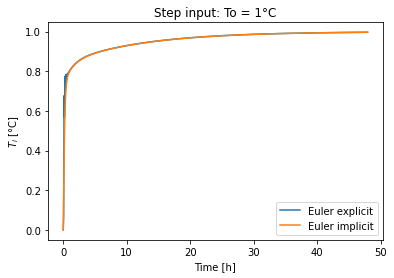

In [23]:
tuto.step_response(duration, dt, As, Bs, Cs, Ds)

> Figure 4. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

#### Simulation by using weather data

For simulation with weather data, we need to indicate the weather data file name and the start and end date of the simulation.

In [24]:
weather_file = './weather_data/FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-03-04 18:00:00'

The simulation is done by using `tuto.P_control()` function with implicit values:
- initial value for the indoor temperature is 20°C.
- auxiliary heat rate flow (internal sources) is zero.
- orientation of the wall:
    - slope 90° (i.e. vertical),
    - azimuth 0 (i.e. South), 
    - latitude 45°.

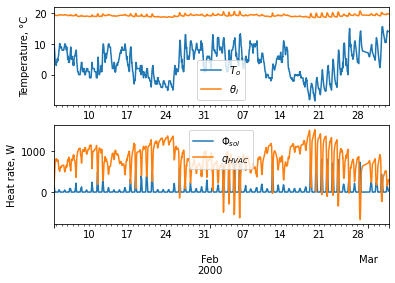

In [37]:
Tisp = 20
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)

> Figure 5. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

Figure 5 shows that, in free running, the indoor temperature follows the outdoor temperature and that the solar radiation influences the indoor temperature. The flow rate of the HVAC system is zero.

### Perfect controller

Let's consider that the controller is perfect, i.e. $K_p \rightarrow \infty$.

In [38]:
Kp = 1e3    # P-controler gain, Kp -> ∞

The steps previously used in order to obtain the assembled circuit are done in the function `tuto.thermal_circuit(Kp)`.

In [39]:
TCa = tuto.thermal_circuit(Kp)

The thermal circuit `TCa` is converted into state-space representation.

In [40]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

The maximum timestep in this case is:

$$ \Delta t_{max} \leq \min -2 / \lambda_i$$

In [41]:
dtmax = min(-2. / np.linalg.eig(As)[0])
dtmax = -2. / min(np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 58.92 s


Let's choose a time step slightly smaller than the maximum time step.

In [42]:
dt = 50   # [s] simulation time step
print(f'dt = {dt} s')

dt = 50 s


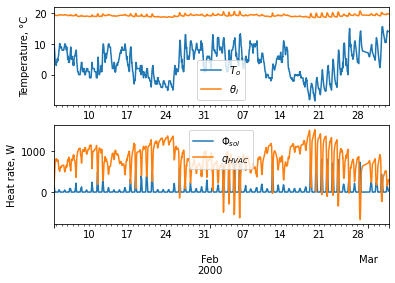

In [43]:
y, q_HVAC, data = tuto.P_control(
    weather_file, start_date, end_date, dt,
    As, Bs, Cs, Ds, Kp, Tisp)
tuto.plot_results(y, q_HVAC, data)

> Figure 6. Simulation with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

Figure 6 shows that, when the controller is *"perfect"*, the indoor temperature follows the setpoint of the indoor temperature and that the flow rate of the HVAC system has positive and negative values (i.e. it is a system that provides heating and cooling).

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# [Control input: heating & cooling and free-running](06Control_Input.ipynb)